In [1]:
import numpy as np
import torch

In [3]:
from math import sqrt

def gaussian2D(radius, sigma=1, dtype=torch.float32, device='cpu'):
    x = torch.arange(
        -radius, radius + 1, dtype=dtype, device=device).view(1, -1)
    y = torch.arange(
        -radius, radius + 1, dtype=dtype, device=device).view(-1, 1)

    h = (-(x * x + y * y) / (2 * sigma * sigma)).exp()

    h[h < torch.finfo(h.dtype).eps * h.max()] = 0
    return h


def gen_gaussian_target(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian_kernel = gaussian2D(
        radius, sigma=diameter / 6, dtype=heatmap.dtype, device=heatmap.device)

    x, y = center

    height, width = heatmap.shape[:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian_kernel[radius - top:radius + bottom,
                                      radius - left:radius + right]
    out_heatmap = heatmap
    torch.max(
        masked_heatmap,
        masked_gaussian * k,
        out=out_heatmap[y - top:y + bottom, x - left:x + right])

    return out_heatmap


In [37]:
heatmap = torch.zeros((10, 10))
out_heatmap = gen_gaussian_target(heatmap, (5, 5), 2)
out_heatmap

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0032, 0.0273, 0.0561, 0.0273, 0.0032, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0273, 0.2369, 0.4868, 0.2369, 0.0273, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0561, 0.4868, 1.0000, 0.4868, 0.0561, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0273, 0.2369, 0.4868, 0.2369, 0.0273, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0032, 0.0273, 0.0561, 0.0273, 0.0032, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])

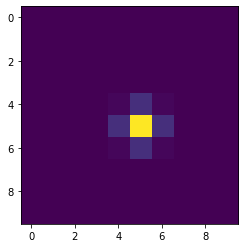

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
out_heatmap = out_heatmap.numpy()
img = Image.fromarray((out_heatmap * 255).astype(np.uint8))
plt.imshow(img)
plt.show()

L


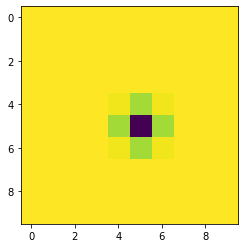

In [36]:
img = Image.fromarray(((1 - out_heatmap) * 255).astype(np.uint8))
plt.imshow(img)
plt.show()

In [52]:
from scipy.ndimage.morphology import distance_transform_cdt
grid_size = 5
dt_threshold = 2
spatial_part = np.zeros((25, ))
spatial_part[4] = 1
spatial_part = np.reshape(spatial_part, [grid_size, grid_size])

# Invert image
spatial_part = -1 * (spatial_part - 1)
# Compute distance transform
spatial_part = distance_transform_cdt(spatial_part, metric='taxicab').astype(np.float32)
print(spatial_part.squeeze())
# Threshold
spatial_part = np.clip(spatial_part, 0, dt_threshold)
# Normalize
spatial_part /= dt_threshold
print(spatial_part.squeeze())
# Invert back
spatial_part = -1. * (spatial_part - 1.)

spatial_part /= np.sum(spatial_part)
spatial_part = spatial_part.flatten()
spatial_part

[[4. 3. 2. 1. 0.]
 [5. 4. 3. 2. 1.]
 [6. 5. 4. 3. 2.]
 [7. 6. 5. 4. 3.]
 [8. 7. 6. 5. 4.]]
[[1.  1.  1.  0.5 0. ]
 [1.  1.  1.  1.  0.5]
 [1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1. ]]


array([-0.  , -0.  , -0.  ,  0.25,  0.5 , -0.  , -0.  , -0.  , -0.  ,
        0.25, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ], dtype=float32)

In [2]:
import numpy as np
import torch
classification = torch.randn(3, 4, 2)
classification

tensor([[[-0.8766, -0.2559],
         [-0.1402,  0.6600],
         [-2.0265, -0.8507],
         [-0.6251, -0.6464]],

        [[-0.0101,  0.0106],
         [ 1.0448,  0.5238],
         [-0.8256, -0.0473],
         [ 0.0519,  1.6967]],

        [[ 1.7956,  0.7747],
         [ 0.5362, -0.1801],
         [ 0.7181, -0.3591],
         [ 0.2667,  1.9853]]])

In [3]:
scores, classes = torch.max(classification, dim=2)
index = torch.topk(scores, 2, dim=1)[1]
index

tensor([[1, 0],
        [3, 1],
        [3, 0]])

In [4]:
anchors = torch.randn(3, 4, 4)
anchors

tensor([[[ 0.0961, -0.2211, -0.1235, -0.4526],
         [ 1.1913, -0.6995,  1.1652, -0.4976],
         [-0.2756,  0.1393, -0.9468,  0.9056],
         [ 1.6276,  0.6425, -1.3039,  0.5388]],

        [[-1.7719, -0.9328, -1.6707, -0.6378],
         [ 0.7151, -1.0701, -1.1874, -0.0166],
         [ 1.7620, -1.6967, -0.8073, -0.1689],
         [ 0.0074, -1.0881, -0.4911,  1.5214]],

        [[-1.4891, -0.7297,  1.2615, -0.4864],
         [-0.6038, -0.5122,  1.5626,  0.6899],
         [-0.5724,  2.0229,  1.1522,  2.0943],
         [-0.8049, -1.2026,  0.2504,  0.4766]]])

In [5]:
torch.index_select(anchors, 1, index[0])

tensor([[[ 1.1913, -0.6995,  1.1652, -0.4976],
         [ 0.0961, -0.2211, -0.1235, -0.4526]],

        [[ 0.7151, -1.0701, -1.1874, -0.0166],
         [-1.7719, -0.9328, -1.6707, -0.6378]],

        [[-0.6038, -0.5122,  1.5626,  0.6899],
         [-1.4891, -0.7297,  1.2615, -0.4864]]])

In [26]:
torch.gather(nums, 1, index)

tensor([[ 2.7379,  0.4971],
        [ 2.0442,  0.6300],
        [ 0.4566, -0.1630]])

In [39]:
nums[index]

tensor([[0.4896, 0.0770],
        [0.6627, 0.9370],
        [0.4200, 0.3213]])

In [54]:
a = torch.randn(3, 4)
a

tensor([[ 1.3468,  0.5561, -0.1046, -2.1203],
        [-0.1744, -0.2209, -0.4993,  0.3010],
        [ 0.3856, -0.2718,  1.3986, -0.2306]])

In [56]:
b = torch.randn((4,))
b

tensor([-1.3560,  0.0881, -0.8153,  1.3512])

In [58]:
i = torch.tensor([[0, 1], [1, 0]]).long()
a[i]

tensor([[[ 1.3468,  0.5561, -0.1046, -2.1203],
         [-0.1744, -0.2209, -0.4993,  0.3010]],

        [[-0.1744, -0.2209, -0.4993,  0.3010],
         [ 1.3468,  0.5561, -0.1046, -2.1203]]])

In [59]:
import numpy as np
import torch
# n, t, b, c
a = torch.randint(1, 10, (2, 4, 3, 4))
a

tensor([[[[5, 7, 3, 2],
          [4, 4, 6, 4],
          [7, 8, 9, 7]],

         [[8, 7, 7, 7],
          [5, 9, 7, 8],
          [4, 7, 4, 3]],

         [[4, 6, 6, 1],
          [2, 3, 4, 3],
          [7, 8, 4, 7]],

         [[9, 7, 5, 6],
          [9, 6, 5, 7],
          [7, 1, 3, 3]]],


        [[[2, 6, 4, 8],
          [9, 5, 6, 5],
          [9, 2, 8, 8]],

         [[2, 8, 5, 9],
          [8, 7, 8, 2],
          [4, 4, 9, 8]],

         [[8, 5, 1, 7],
          [2, 2, 3, 8],
          [5, 1, 8, 6]],

         [[2, 5, 4, 1],
          [7, 8, 1, 6],
          [1, 6, 4, 6]]]])

In [60]:
inds = torch.tensor([[2, 1], [1, 2]]).long()
inds


tensor([[2, 1],
        [1, 2]])

In [61]:
b = a.permute(0, 2, 1, 3)
print(b.shape)
b

torch.Size([2, 3, 4, 4])


tensor([[[[5, 7, 3, 2],
          [8, 7, 7, 7],
          [4, 6, 6, 1],
          [9, 7, 5, 6]],

         [[4, 4, 6, 4],
          [5, 9, 7, 8],
          [2, 3, 4, 3],
          [9, 6, 5, 7]],

         [[7, 8, 9, 7],
          [4, 7, 4, 3],
          [7, 8, 4, 7],
          [7, 1, 3, 3]]],


        [[[2, 6, 4, 8],
          [2, 8, 5, 9],
          [8, 5, 1, 7],
          [2, 5, 4, 1]],

         [[9, 5, 6, 5],
          [8, 7, 8, 2],
          [2, 2, 3, 8],
          [7, 8, 1, 6]],

         [[9, 2, 8, 8],
          [4, 4, 9, 8],
          [5, 1, 8, 6],
          [1, 6, 4, 6]]]])

In [65]:
print(b.shape)
b[torch.arange(2)[:, None], inds]

torch.Size([2, 3, 4, 4])


tensor([[[[7, 8, 9, 7],
          [4, 7, 4, 3],
          [7, 8, 4, 7],
          [7, 1, 3, 3]],

         [[4, 4, 6, 4],
          [5, 9, 7, 8],
          [2, 3, 4, 3],
          [9, 6, 5, 7]]],


        [[[9, 5, 6, 5],
          [8, 7, 8, 2],
          [2, 2, 3, 8],
          [7, 8, 1, 6]],

         [[9, 2, 8, 8],
          [4, 4, 9, 8],
          [5, 1, 8, 6],
          [1, 6, 4, 6]]]])

In [68]:
a[torch.arange(2)[:, None], :, inds]

tensor([[[[7, 8, 9, 7],
          [4, 7, 4, 3],
          [7, 8, 4, 7],
          [7, 1, 3, 3]],

         [[4, 4, 6, 4],
          [5, 9, 7, 8],
          [2, 3, 4, 3],
          [9, 6, 5, 7]]],


        [[[9, 5, 6, 5],
          [8, 7, 8, 2],
          [2, 2, 3, 8],
          [7, 8, 1, 6]],

         [[9, 2, 8, 8],
          [4, 4, 9, 8],
          [5, 1, 8, 6],
          [1, 6, 4, 6]]]])

In [25]:
d[range(1), ]

tensor([[[6, 3],
         [3, 3]],

        [[3, 3],
         [6, 3]]])

In [2]:
import numpy as np
import torch
model = torch.load('./venus/0/latest.pth', 'cpu')

In [4]:
model['state_dict'].keys()

odict_keys(['backbone.conv1.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.layer1.0.conv1.weight', 'backbone.layer1.0.bn1.weight', 'backbone.layer1.0.bn1.bias', 'backbone.layer1.0.bn1.running_mean', 'backbone.layer1.0.bn1.running_var', 'backbone.layer1.0.bn1.num_batches_tracked', 'backbone.layer1.0.conv2.weight', 'backbone.layer1.0.bn2.weight', 'backbone.layer1.0.bn2.bias', 'backbone.layer1.0.bn2.running_mean', 'backbone.layer1.0.bn2.running_var', 'backbone.layer1.0.bn2.num_batches_tracked', 'backbone.layer1.0.conv3.weight', 'backbone.layer1.0.bn3.weight', 'backbone.layer1.0.bn3.bias', 'backbone.layer1.0.bn3.running_mean', 'backbone.layer1.0.bn3.running_var', 'backbone.layer1.0.bn3.num_batches_tracked', 'backbone.layer1.0.downsample.0.weight', 'backbone.layer1.0.downsample.1.weight', 'backbone.layer1.0.downsample.1.bias', 'backbone.layer1.0.downsample.1.running_mean', 'backbone.

In [5]:
model1 = torch.load('./venus/1/latest.pth', 'cpu')

In [7]:
model1['state_dict'].keys()

odict_keys(['backbone.conv1.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.layer1.0.conv1.weight', 'backbone.layer1.0.bn1.weight', 'backbone.layer1.0.bn1.bias', 'backbone.layer1.0.bn1.running_mean', 'backbone.layer1.0.bn1.running_var', 'backbone.layer1.0.bn1.num_batches_tracked', 'backbone.layer1.0.conv2.weight', 'backbone.layer1.0.bn2.weight', 'backbone.layer1.0.bn2.bias', 'backbone.layer1.0.bn2.running_mean', 'backbone.layer1.0.bn2.running_var', 'backbone.layer1.0.bn2.num_batches_tracked', 'backbone.layer1.0.conv3.weight', 'backbone.layer1.0.bn3.weight', 'backbone.layer1.0.bn3.bias', 'backbone.layer1.0.bn3.running_mean', 'backbone.layer1.0.bn3.running_var', 'backbone.layer1.0.bn3.num_batches_tracked', 'backbone.layer1.0.downsample.0.weight', 'backbone.layer1.0.downsample.1.weight', 'backbone.layer1.0.downsample.1.bias', 'backbone.layer1.0.downsample.1.running_mean', 'backbone.